In [1]:
from Bio import Entrez
from Bio.Seq import Seq
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["legend.frameon"] = False
%matplotlib inline

Let's let the nice folks at NCBI know who we are.

In [2]:
Entrez.email = "mi6568@student.uni-lj.si"

In [3]:
# In order to import from the python file without hassle, we add the current
# directory to the python path
import sys; sys.path.append(".")
from helper_functions import load_record, extract_gt_orfs, find_all_orfs, translate_to_protein, codons, permutate, find_all_orfs_nested

# Paramecium tetraurelia

Paramecia are unicellular organisms, which move around using cilia. Cilia are like little hairs attached to the cell membrane, which the animal can vibrate to move around.

![](https://upload.wikimedia.org/wikipedia/commons/b/bd/Инфузория_туфелька_поедает_бактерии%21.gif)

Paramecia are widespread in freshwater, brackish, and marine environments and are often very abundant in stagnant basins and ponds. If you want, you can read more about them on [Wikipedia](https://en.wikipedia.org/wiki/Paramecium).

This is a model organism, meaning it has been very thoroughly studied. This means we can easily check our work for any analysis we might do because we have the ground truth, which biologists have spent decades gathering for us. We're going to examine the DNA sequence of Paramecium and write a program to find gene candidates. Because we have the ground truth, we can then check how many of our ORF candidates are actually genes.

Every organism in NCBI has an associated unique identifier, which we can use to download various genomes and other kinds of data to our computer. The NCBI ID for Paramecium is _NC_006058_.

In [4]:
organism_id = "NC_006058"  # Paramecium tetraurelia

Fetch the Paramecium genome from NCBI. To check you have the right one, the genome should be 984,602 bases long.

_Hint_: Use the `Entrez.efetch` (http://biopython.org/DIST/docs/tutorial/Tutorial.html#sec149) and `SeqIO.read` (http://biopython.org/DIST/docs/tutorial/Tutorial.html#sec37) functions from biopython.

In [5]:
# TODO
record = load_record(organism_id)
print(record, "\nlen: ", len(record.seq))

ID: NC_006058.1
Name: NC_006058
Description: Paramecium tetraurelia macronuclear, complete genome
Database cross-references: Project:12726, BioProject:PRJNA12726
Number of features: 1397
/molecule_type=DNA
/topology=linear
/data_file_division=INV
/date=03-MAY-2010
/accessions=['NC_006058']
/sequence_version=1
/keywords=['RefSeq', 'macronuclear chromosome']
/source=Paramecium tetraurelia strain d4-2
/organism=Paramecium tetraurelia strain d4-2
/taxonomy=['Eukaryota', 'Sar', 'Alveolata', 'Ciliophora', 'Intramacronucleata', 'Oligohymenophorea', 'Peniculida', 'Parameciidae', 'Paramecium']
/references=[Reference(title='High coding density on the largest Paramecium tetraurelia somatic chromosome', ...), Reference(title='Paramecium megabase sequencing project', ...), Reference(title='Direct Submission', ...), Reference(title='Direct Submission', ...)]
/comment=PROVISIONAL REFSEQ: This record has not yet been subject to final
NCBI review. The reference sequence was derived from CR548612.
Seq('

## Problem 1: Finding gene candidates

Find all the open reading frames (ORFs) in the genome. We define an ORF to be the longest contiguous sequence of triplets (codons) between a start and a stop codon. For instance, TTATGAAAATGAAATGATT contains one ORF -- ATGAAAATGAAATGA spanning from locations 2 to 17.

**TASK:**
Implement the `find_orfs` and `find_all_orfs` functions in `helper_functions.py`. `find_orfs` should find ORFs for a single offset e.g. [ATGTAATGTTGATTA]TG, ignoring the final TG. `find_all_orfs` should use `find_orfs` to find _all_ the ORFs in a sequence, i.e. [ATGTAATGTTGATTA]TG, A[TGTAATGTTGATTAT]G, AT[GTAATGTTGATTATG], as well as the ORFs on the reverse complements. See the docstrings for expected return types. **[10 points]**

Hint: The number of ORFs on the positive and negative strands should be roughly equal.

In [6]:
# Paramecium is a bit special and uses only a single stop codon
start_codons = ["ATG"]
stop_codons = ["TGA"]

In [7]:
print("Finding ORFs using start/stop codons...")
orf_candidates = find_all_orfs(record.seq, start_codons, stop_codons)
print(f"{len(orf_candidates)} ORF candidates found")

Finding ORFs using start/stop codons...
16646 ORF candidates found


## Problem 2: Finding true genes

We now have quite a large number of ORF candidates. Some of these might be true genes, some may not. In practice, biologists will often look through each ORF manually to determine if it is a gene or not. We want to help them by reducing the number of ORFs they'll have to look through. The simplest way to reduce this number is to simply set a threshold for our ORF lengths. As you saw in lectures, we can determine a sensible threshold using a permutation test.

**TASK:**

**a)** Perform a permutation test with 100 repetitions and plot the distribution of ORF lengths in these random sequences. Overlay this with the ORF lengths you found using your ORF finder. Determine a threshold such that we keep only sequences with $p < 0.01$. Clearly mark this threshold on your plot. Save your threshold into the `bacteria_threshold` variable and save your plot into `problem2-permutation.png`.
**[5 points]**

Hint: For plotting, you can use the [`hist`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html) function from [matplotlib](https://matplotlib.org/stable/index.html). You may also consider using the log-scale for the y-axis.

In [8]:
# TODO
orf_lengths = np.array([oc[2]-oc[1] for oc in orf_candidates])/3
np.max(orf_lengths)

3558.0

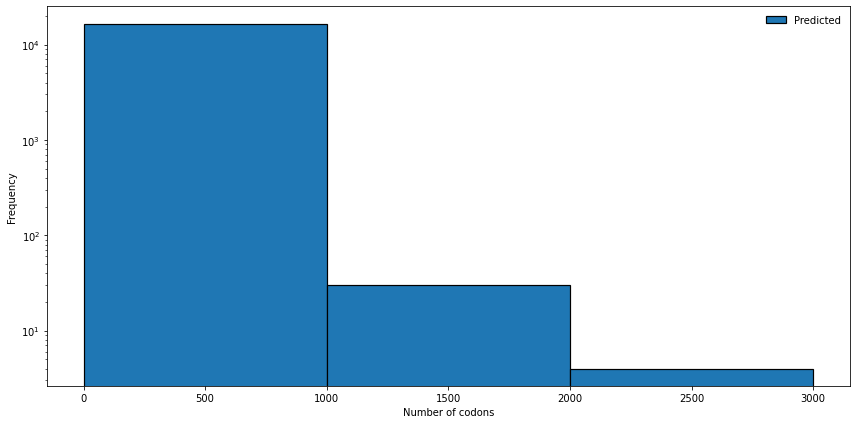

In [9]:
fig, ax = plt.subplots(figsize=(12, 6), sharex=True)
hist_kwargs = dict(bins=list(range(0, 3700, 1000)), edgecolor="k", lw=1.2)
ax.hist(orf_lengths, color="tab:blue", label="Predicted", **hist_kwargs)
ax.set_xlabel("Number of codons"), ax.set_ylabel("Frequency")
ax.legend()
ax.set_yscale("log")
plt.tight_layout();

In [10]:
bacteria_threshold = -1
orf_s_lengths = permutate(record.seq, start_codons, stop_codons)
orf_s_lengths = np.sort(orf_s_lengths)
bacteria_threshold = orf_s_lengths[int(0.99*len(orf_s_lengths))]
print(bacteria_threshold)

255.0


In [11]:
bacteria_threshold = 254

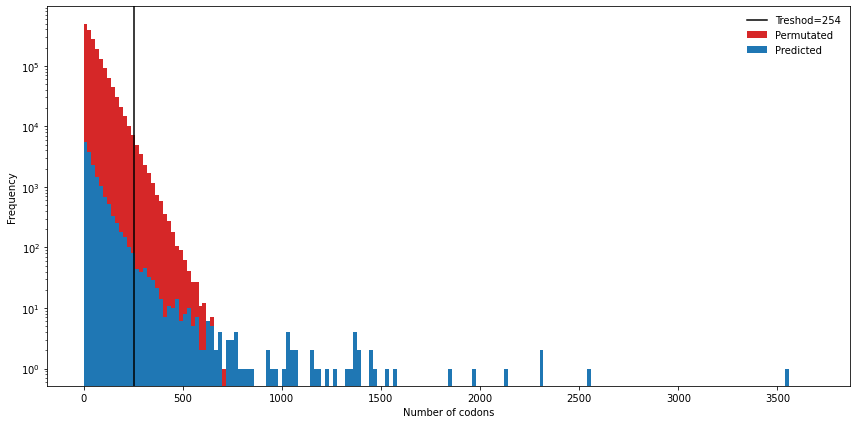

In [12]:
fig, ax = plt.subplots(figsize=(12, 6), sharex=True)
hist_kwargs = dict(bins=list(range(0, 3700, 20)), lw=1.2)
ax.hist(orf_s_lengths, color="tab:red", label="Permutated", **hist_kwargs)
ax.set_xlabel("Number of codons"), ax.set_ylabel("Frequency")
ax.hist(orf_lengths, color="tab:blue", label="Predicted", **hist_kwargs)
ax.set_xlabel("Number of codons"), ax.set_ylabel("Frequency")
ax.axvline(x=bacteria_threshold, color='k', label="Treshod=254")
ax.legend()
ax.set_yscale("log")
plt.tight_layout();
plt.savefig('problem2-permutation.png')

Is this a good threshold? As we said in the beginning, Paramecium tetraurelia is a well-studied organism, so we can easily compare our filtered ORFs with the ground truth ORFs. There are many metrics we can use to evaluate our accuracy, but here, we'll focus on three: precision, recall, and the F1 score (please consult Wikipedia if you aren't familiar with these metrics). By using the threshold we determined in **a)**, we can discard all the ORFs that are shorter than our threshold. We can then compare this to the ground truth ORFs.

Could a different threshold give better precision/recall/F1 scores? Again, we can check. We'll generate a list of possible thresholds, and compute precision/recall/F1 scores for each of the thresholds. Plot all three metrics into a single figure. Clearly mark the permutation test threshold. Is the permutation test threshold good? Could we determine a better threshold?

**TASK:**

**b)** Plot the precision/recall/F1 curves for other possible thresholds into a single figure. Clearly mark the permutation test threshold. Save the resulting figure to `problem2-proc.png`. Write down any observations and answers to the above questions into the `bacteria_comments` variable.
**[5 points]**

We start by extracting the ground truth genes from the NCBI record that we downloaded earlier. Please use the provided `extract_gt_orfs` function in `helper_functions.py` to extract the ground truth coding regions.

In [13]:
print("Extracting ORFs from NCBI annotation...")
orfs_gt = extract_gt_orfs(record, start_codons, stop_codons, verbose=False)
print(f"{len(orfs_gt)} ground truth ORFs found")

Extracting ORFs from NCBI annotation...
90 ground truth ORFs found


In [14]:
gt_orf_length = np.array([c[2] - c[1] for c in orfs_gt]) / 3

In [15]:
# TODO
predictons = []
recalls = []
f1s = []
subset = np.array(orf_candidates)
trashhold = int(max(gt_orf_length))
for i in range(trashhold):
    lenghts = np.array([c[2] - c[1] for c in subset]) / 3
    ind = np.where(lenghts[:] > i)
    subset = subset[ind]
    tp = len(np.intersect1d(subset, orfs_gt))
    predicton = tp / len(subset)
    recall = tp / len(orfs_gt)
    predictons.append(predicton)
    recalls.append(recall)
    f1s.append(2 * predicton * recall / (predicton + recall))
    
    
trashholds = range(trashhold)
print(trashholds[np.argmax(f1s)], max(f1s))
trashhold = 566

566 0.2289156626506024


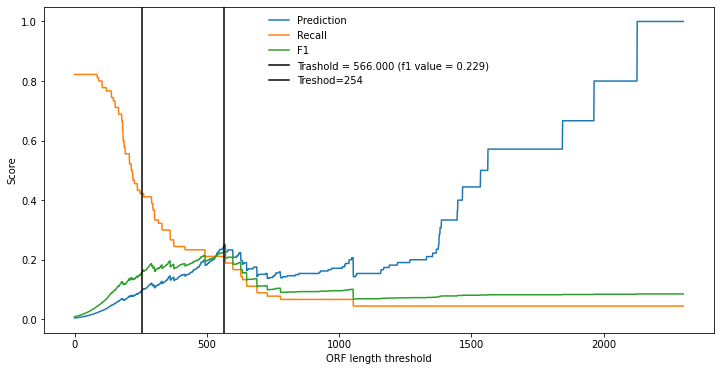

In [35]:
plt.figure(figsize=(12,6))
text= "Trashold = {:.3f} (f1 value = {:.3f})".format(trashhold, max(f1s))
plt.plot(trashholds, predictons, label='Prediction')
plt.plot(trashholds, recalls, label='Recall')
plt.plot(trashholds, f1s, label='F1')
plt.ylabel('Score')
plt.xlabel('ORF length threshold')
plt.axvline(x=trashhold, color='k', label=text)
plt.axvline(x=bacteria_threshold, color='k', label="Treshod=254")
plt.legend(loc='best')
plt.savefig('problem2-proc.png')
plt.show()

In [17]:

bacteria_comments = """
Yes, the trashold we got with perutation test could be better. I choose 566 for (new) trashold, because in that point f1 function has the highest value (0.229)
"""

# SARS-CoV-2

SARS-CoV-2 is the prolific virus that causes the COVID-19 disease. I am sure most of you are well aware of what the disease does, so we'll skip any long-winded introduction. Instead, we'll jump straight into the genome of this pesky little virus.

![](https://www.klinika-golnik.si/storage/_sites/golnik/app/media/Novice/cov-19.jpg)

First, we need to obtain the viral genome from NCBI.

In [18]:
organism_id = "NC_045512"  # SARS-CoV-2

In [19]:
# TODO
record = load_record(organism_id)
print(record, "\nlen: ", len(record.seq))

ID: NC_045512.2
Name: NC_045512
Description: Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome
Database cross-references: BioProject:PRJNA485481
Number of features: 57
/molecule_type=ss-RNA
/topology=linear
/data_file_division=VRL
/date=18-JUL-2020
/accessions=['NC_045512']
/sequence_version=2
/keywords=['RefSeq']
/source=Severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2)
/organism=Severe acute respiratory syndrome coronavirus 2
/taxonomy=['Viruses', 'Riboviria', 'Orthornavirae', 'Pisuviricota', 'Pisoniviricetes', 'Nidovirales', 'Cornidovirineae', 'Coronaviridae', 'Orthocoronavirinae', 'Betacoronavirus', 'Sarbecovirus']
/references=[Reference(title='A new coronavirus associated with human respiratory disease in China', ...), Reference(title='Programmed ribosomal frameshifting in decoding the SARS-CoV genome', ...), Reference(title='The structure of a rigorously conserved RNA element within the SARS virus genome', ...), Reference(title="A phyl

## Problem 3: SARS-CoV-2 gene candidates

_You_ are now the biologist. This time we have no ground truth annotations about SARS-CoV-2 from NCBI, so it is up to you to find potential gene candidates and try to determine what each gene does.

**TASK:**
Run your ORF finder on the SARS-CoV-2 genome. Again, using a permutation test with 100 repetitions, determine a threshold for ORF lengths such that we keep only sequences with $p < 0.01$. Plot the distribution of ORF lengths in the random sequences and overlay this with your ORF lengths. Clearly mark the permutation test threshold. Save your plot to `problem3.png`. Save your threshold into the `covid_threshold` variable.
**[5 points]**

In [20]:
start_codons = ["ATG"]
stop_codons = ["TAA", "TAG", "TGA"]

In [21]:
# TODO
print("Finding ORFs using start/stop codons...")
sars_orf_candidates = find_all_orfs(record.seq, start_codons, stop_codons)
print(f"{len(sars_orf_candidates)} ORF candidates found")

Finding ORFs using start/stop codons...
711 ORF candidates found


In [22]:
covid_threshold = -1
orf_s_lengths = permutate(record.seq, start_codons, stop_codons)
orf_s_lengths = np.sort(orf_s_lengths)
covid_threshold = orf_s_lengths[int(0.99*len(orf_s_lengths))]
print(covid_threshold)

69.0


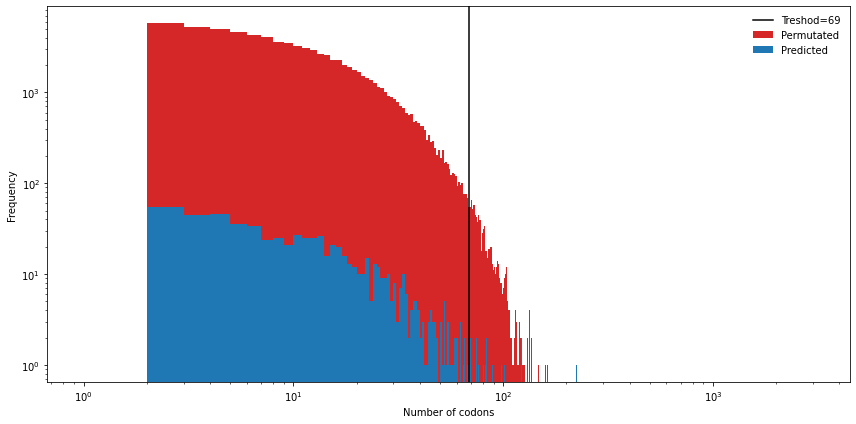

In [23]:
orf_lengths = np.array([oc[2]-oc[1] for oc in sars_orf_candidates])/3
fig, ax = plt.subplots(figsize=(12, 6), sharex=True)
hist_kwargs = dict(bins=list(range(0, 3000)), lw=1.2)
ax.hist(orf_s_lengths, color="tab:red", label="Permutated", **hist_kwargs)
ax.set_xlabel("Number of codons"), ax.set_ylabel("Frequency")
ax.hist(orf_lengths, color="tab:blue", label="Predicted", **hist_kwargs)
ax.set_xlabel("Number of codons"), ax.set_ylabel("Frequency")
ax.axvline(x=covid_threshold, color='k', label="Treshod=69")
ax.legend()
ax.set_yscale("log")
ax.set_xscale("log")
plt.tight_layout();
plt.savefig('problem3.png')

In [24]:
covid_threshold = 69
covid_subset = np.array(sars_orf_candidates)[orf_lengths[:] >= covid_threshold]

## Problem 4: Determining gene functionality

In the final problem, you will use NCBIs online blastp tool to determine whether or not each ORF you found is an actual gene, and if it is -- what it does.

BLASTp is a sequence alignment tool that you will learn about in the upcoming lectures and explore in more detail in the next homework. But for now, you can think of it like this: given a protein sequence, BLASTp looks through the genomes of all known animals and sees if there are any parts of the protein sequence that match the different animal sequences. This works because genes from closely related organisms usually don't differ all that much and perform the same function in different organisms. For example, if we have some gene from a brown labrador puppy, we can reasonably expect that gene to have a fairly similar nucleotide sequence (and consequently protein sequence) to that same gene in black labrador puppies. Or in the case SARS-CoV-2, the gene nucleotide sequences will probably be similar to the sequences of related coronaviruses.

![](https://www.economist.com/img/b/1000/563/90/sites/default/files/20200314_FBD001.jpg)

**TASK**:

**a)** Translate each of your filtered ORFs into the corresponding protein sequence. Implement the `translate_to_protein` function in `helper_functions.py`. Do not use Biopython for this in this homework -- we want you to implement this yourself. Stop codons should translate into an empty string (""). **[5 points]**

**b)** Run each protein sequence through [NCBI BLASTp](https://blast.ncbi.nlm.nih.gov/Blast.cgi?PROGRAM=blastp&PAGE_TYPE=BlastSearch&LINK_LOC=blasthome). Look at the picture of the SARS-CoV-2 virus above, and try to match each of the ORFs you found to a protein type, e.g. ORF1 may be a spike protein, or ORF5 might be an envelope protein. Save your answers into the `covid_proteins` variable as a dictionary of lists, where the dictionary keys are what you see in the picture. The lists should hold the tuples specifying the appropriate ORFs in the same format that is returned by `find_all_orfs`. **[10 points]**

You should be able to determine where most proteins go by their names alone. Please do not go digging through the _COMMENT_ field, as that often contains complicated biological terminology and might mislead you. The goal is to find at least 3 proteins that you can confidently determine by name alone. You will be penalized for each incorrect answer. In case your filtering returns a large number of ORFs (which it shouldn't), you may want to look at the longest ORFs first, as these are more likely to be true genes.

You might also find [EMBLs Protein Similarity Search](https://www.ebi.ac.uk/Tools/sss/fasta/) useful. The descriptions there sometimes tend to be more readable.

In [25]:
# TODO
covid_proteins_a = []
for orf in covid_subset:
    if orf[0] == 1:
        covid_proteins_a.append(translate_to_protein(record.seq[orf[1]:orf[2]]))
    else:
        reverse = record.seq[orf[1]:orf[2]].reverse_complement()
        covid_proteins_a.append(translate_to_protein(reverse))

In [26]:
covid_proteins = {
    "Envelope protein": [(1, 26244, 26472)],
    "Membrane protein": [(1, 26522, 27191)],
    "Spike protein": [(1, 21535, 25384)],
    "Nucleocapsid protein": [(1, 28273, 29533)],
    "Lipid membrane": [],
}

In [27]:
for p in covid_proteins:
    if covid_proteins[p] != []:
        print(p, ':', covid_proteins_a[np.where(covid_subset[:, 1] == covid_proteins[p][0][1])[0][0]])

Envelope protein : MYSFVSEETGTLIVNSVLLFLAFVVFLLVTLAILTALRLCAYCCNIVNVSLVKPSFYVYSRVKNLNSSRVPDLLV
Membrane protein : MADSNGTITVEELKKLLEQWNLVIGFLFLTWICLLQFAYANRNRFLYIIKLIFLWLLWPVTLACFVLAAVYRINWITGGIAIAMACLVGLMWLSYFIASFRLFARTRSMWSFNPETNILLNVPLHGTILTRPLLESELVIGAVILRGHLRIAGHHLGRCDIKDLPKEITVATSRTLSYYKLGASQRVAGDSGFAAYSRYRIGNYKLNTDHSSSSDNIALLVQ
Spike protein : MFLLTTKRTMFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYST

## Bonus problem: Visualizing ORF candidates

You may have noticed in problem 2 that even when keeping all the genes, our recall was well below 1. This means that even without any filtering, we weren't able to find all the ORFs that are actually genes. The reason for this is that we defined ORFs to be the longest contiguous sequence of codons between a start and a stop codon. This is a simplification of what really happens in biology. Not all start codons actually determine the beginning of a coding (gene) sequence. ORFs themselves can contain start codons since the ATG codon itself codes for Methionine. To be completely thorough, each start codon should start its own ORF.

In this exercise, we will define an ORF to be **any** contiguous sequence of codons between a start and a stop codon. For instance, ATGAAAATGAAATGA now contains two ORFs: ATGAAAATGAAATGA and ATGAAATGA.

**TASK**: Implement the `find_all_orfs_nested` function in `helper_functions.py`, following the above definition of an ORF.
Visualize where on the genome the ORF candidates are found. Highlight which of the ORF candidates are true genes. Save your plot to `problem-orf-viz.png`. **[5 points]**

You can look at this image for a general direction: https://www.ncbi.nlm.nih.gov/nuccore/NC_002549.1?report=graph. You don't need to worry about optimizing the layout -- putting each ORF candidate in its own row is fine. Bonus points if you do optimize the layout though :) If you have a different idea for the visualization, that's even better. Feel free to apply any kind of filtering to the ORFs you plot.

In [28]:
# TODO
print("Finding ORFs using start/stop codons...")
sars_orf_candidates_nested = find_all_orfs_nested(record.seq, start_codons, stop_codons)
print(f"{len(sars_orf_candidates_nested)} ORF candidates found")

Finding ORFs using start/stop codons...
378974 ORF candidates found


In [29]:
print("Extracting ORFs from NCBI annotation...")
orfs_gt = extract_gt_orfs(record, start_codons, stop_codons, verbose=False)
print(f"{len(orfs_gt)} ground truth ORFs found")

Extracting ORFs from NCBI annotation...
11 ground truth ORFs found


In [30]:
inters = np.intersect1d(orfs_gt, sars_orf_candidates_nested)
len(inters)

23

## Bonus problem: How big are viruses?

How does SARS-CoV-2 compare to other viruses? Is it a small or large virus? We can't really say without a reference. Thankfully, NCBI has us covered. NCBI Virus is a subset of NCBI dedicated only to viral sequences. To determine the size of SARS-CoV-2, we'll download a bunch of viral sequences and simply compare the lengths of their genomes. We could compare other things as well e.g. the number of genes, but it's sufficient to compare the sequence lengths for this homework.

**TASK**: Download all complete virus genomes from [NCBI Virus](https://www.ncbi.nlm.nih.gov/labs/virus/vssi/#/virus). There are around 10,000 of them. Create an informative visualization of the distribution of virus sequence lengths. Clearly mark the length of the SARS-CoV-2 virus. Save your plot to `problem-virus-size.png`. Is the virus short or long compared to other viruses? Do anything else stand out? Save your answers in the `virus_size_comments` variable. **[5 points]**

Potential questions you might want to answer might be is the number of DNA vs number of RNA viruses. Which are more prevalent? Is any type of virus longer than other types? Where do other viruses fall in this distribution? Some potentially interesting viruses might be SARS and MERS (we heard that SARS-CoV-2 is closely related to those two), ebola, HIV, the common cold, hepatitis a/b/c, ...

In [31]:
# TODO

In [32]:
virus_size_comments = """
"""